In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from configparser import ConfigParser
import pathlib as pl

import joblib as jl
import numpy as np
import xarray as xr
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from webcolors import name_to_hex

from src.data.rasters import load_site_formated_raster
from src.root_path import config_path, root_path
from src.utils.subsets import good_sites
from src.metrics.simple_diff import ctx_effects_as_DF

from src.models.decoder import unfold_rep_ctx_prb, get_svm_accuracy, decode_and_plot
from src.data.diagonalization import plot_eg_diag, diag_and_scale, load_site_dense_raster
from src.visualization.palette import add_opacity
from src.metrics.consolidated_tstat import tstat_cluster_mass
from src.metrics.summaryDF import create_summary_DF

from src.visualization.interactive import plot_site_coverages, plot_raw_pair_array
from src.visualization.palette import Grey, FOURCOLOR, TENCOLOR

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


# purpose
after a first exploration of alternatives for densifying the naturally sparse contextual effects, we have simply
forced the response of all neurons to be equal for any given context (once the probe effect is subtracted),
while at the same time preserving the total response across all neurons.

For example, in a system of 2 neurons, x and y,
their original response to the context i are different: xi != yi and
xi + yi = A, where A is the total activity level.

After the densification, the modified responses are equal and the total
activity is preserved: xi == yi == A/2

xi == yi defines a diagonal, thus we name this specific approach of densification a **diagonalization**


this notebook presents a refactoring and functionalization of the diagoalization procedure, so we can apply it across
all the sites in our dataset


In [15]:
# Kinda baseline minimal parameterse
raster_meta = {'reliability': 0.1,  # r value
               'smoothing_window': 0,  # ms
               'raster_fs': 20,
               'zscore': True,
               'stim_type': 'permutations'}

# example from figure 1?
eg_cellid, eg_ctx_pair, eg_prb = 'ARM021b-36-8', [0,1], 3 # example from figure 2, with nice PSTHs
eg_cellid, eg_ctx_pair, eg_prb = 'ARM017a-09-1', [0,1], 3
eg_cellid, eg_ctx_pair, eg_prb = 'ARM017a-39-2', [0,1], 3
eg_site = eg_cellid.split('-')[0]

# load cache of sigle cell rasters for this example site
if load_site_formated_raster.check_call_in_cache(eg_site, **raster_meta):
    raster, cellids = load_site_formated_raster(eg_site, **raster_meta)
    print(f'####\n'
          f'found and loaded cache for {eg_site}')
else:
    print(f"cant load load_site_formated_raster with {raster_meta}.\n this should be cached, why is it failing? ")


# small data subset with 2 neurons, 1 probe, and 1 timepoint, usefull for development and debuging
test_raster = raster[:,np.asarray([19,21]),...][...,0,0][:,:,:,None,None] # 2 neurons, 1 probe, 1 time point

####
found and loaded cache for ARM017a


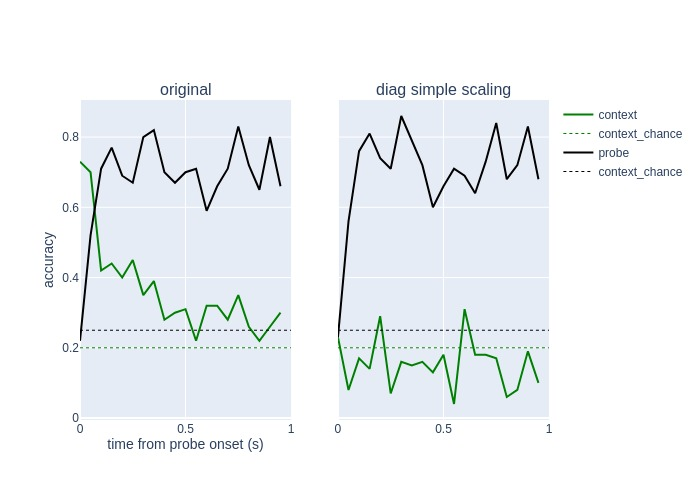

In [16]:
diag_simple_scaling = diag_and_scale(raster, mode='mean_var')

fig = make_subplots(rows=1, cols=2, shared_yaxes='all', shared_xaxes='all',
                    subplot_titles=['original', 'diag simple scaling'])

for cc, arr in enumerate([raster, diag_simple_scaling]):
    showlegend = True if cc == 0 else False
    f, _, _ = decode_and_plot(arr,showlegend=showlegend)
    f = f['data']
    fig.add_traces(f, rows=[1]*len(f), cols=[cc+1]*len(f))

_ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0, row=1, col=1)
_ = fig.update_yaxes(title_text='accuracy', title_standoff=0, row=1, col=1)

fig.show(renderer='jpeg')

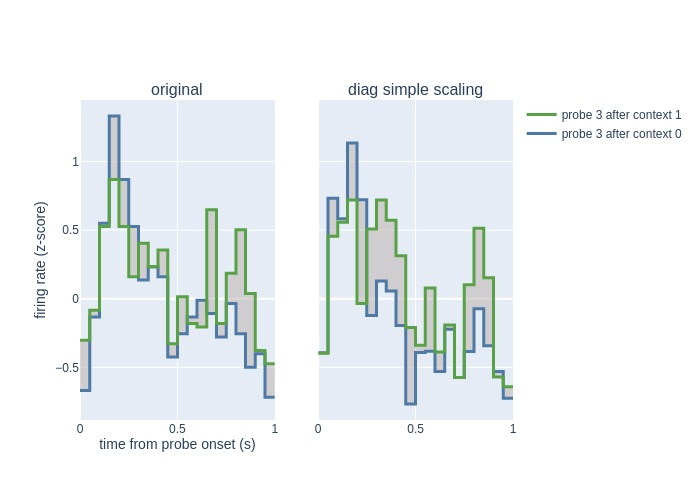

In [17]:
fig = make_subplots(rows=1, cols=2, shared_yaxes='all', shared_xaxes='all',
                    subplot_titles=['original', 'diag simple scaling'])


for cc, arr in enumerate([raster, diag_simple_scaling]):
    showlegend = True if cc == 0 else False
    f = plot_raw_pair_array(arr, cellids, eg_cellid, eg_ctx_pair, eg_prb, raster_meta['raster_fs'],
                    part='probe', hightlight_difference=True, CI=None, showlegend=showlegend)['data']
    fig.add_traces(f, rows=[1]*len(f), cols=[cc+1]*len(f))

_ = fig.update_xaxes(title_text='time from probe onset (s)', title_standoff=0, row=1, col=1)
_ = fig.update_yaxes(title_text='firing rate (z-score)', title_standoff=0, row=1, col=1)

fig.show(renderer='jpeg')

# better coverage
the idea being to calculate the same cluster mass t-score integral metrics for the diagonalized data,
such that it can be directly compared with the coverages of the same neurons in the original data.
The T-score cluster mass is quite compute intesive due to the motecarlo, however, we just need the one example site

for that purpose extend the traditional pipeline of caltulating and cacheing tstats and recopilating them in dataframes

In [18]:
montecarlo = 11000
cluster_threshold = 0.05
loading_func = 'dense'
_ = tstat_cluster_mass(eg_site, cluster_threshold=cluster_threshold, montecarlo=montecarlo,
                         raster_meta=raster_meta, load_fn=loading_func)

# which one do i need??
multiple_corrections = {
    'bf_cp': [1, 2],
    'bf_ncp': [0, 1, 2]
}

dense_eg_DF_file = pl.Path(config['paths']['analysis_cache']) / f'230220_dense_eg_DF'
create_summary_DF([eg_site], [loading_func], [cluster_threshold], 0.05, montecarlo, raster_meta,
                  ['integral', 'last_bin'], ['real'],
                  multiple_corrections, dense_eg_DF_file, ['delta_FR'], keep_pvalues=False, recacheDF=True)

dense_eg_DF = jl.load(dense_eg_DF_file)

all sites: 
['ARM017a']



100%|██████████| 1/1 [00:00<00:00, 21.98it/s]

             id context_pair probe      value    metric mult_comp_corr  \
0  ARM017a-01-3        00_01     1  96.575134  integral          bf_cp   
1  ARM017a-01-4        00_01     1  96.575134  integral          bf_cp   
2  ARM017a-02-1        00_01     1   0.000000  integral          bf_cp   
3  ARM017a-04-1        00_01     1  96.575134  integral          bf_cp   
4  ARM017a-04-2        00_01     1  96.575134  integral          bf_cp   
5  ARM017a-06-1        00_01     1  96.575134  integral          bf_cp   
6  ARM017a-07-1        00_01     1  96.575134  integral          bf_cp   
7  ARM017a-07-2        00_01     1  96.575134  integral          bf_cp   
8  ARM017a-09-1        00_01     1  96.575134  integral          bf_cp   
9  ARM017a-10-1        00_01     1   0.000000  integral          bf_cp   

  analysis diff_metric     site region source cluster_threshold stim_count  
0    dense    delta_FR  ARM017a    PEG   real              0.05          4  
1    dense    delta_FR  ARM017a

#### problematic instanceses
we have found that the fano scaling of diagonalization might fail for numerical reasons, here we disect these reasons:
likely zero variance. and the consequencess it has over the final diagonalization

In [19]:
simple_diag = diag_and_scale(raster, mode='mean_var', return_problem=False)
fano_diag, (Sm, Sc) = diag_and_scale(raster, mode='fano_var', return_problem=True)

print(Sm.shape)
print(f"problems in mean scaler:{np.any(Sm)}")
print(f"problems in cluster scaler:{np.any(Sc)}")
pwhere = np.argwhere(Sc)
print(f"{len(pwhere)} problematic instancese, {len(pwhere)/Sc.size* 100} of all")
print(pwhere)

div by 0 in ClustVar 46
(1, 34, 1, 4, 20)
problems in mean scaler:True
problems in cluster scaler:True
2720 problematic instancese, 100.0 of all
[[ 0  0  0  0  0]
 [ 0  0  0  0  1]
 [ 0  0  0  0  2]
 ...
 [ 0 33  0  3 17]
 [ 0 33  0  3 18]
 [ 0 33  0  3 19]]


/home/mateo/code/context_probe_analysis/src/data/diagonalization.py:95: RuntimeWarning:

divide by zero encountered in true_divide



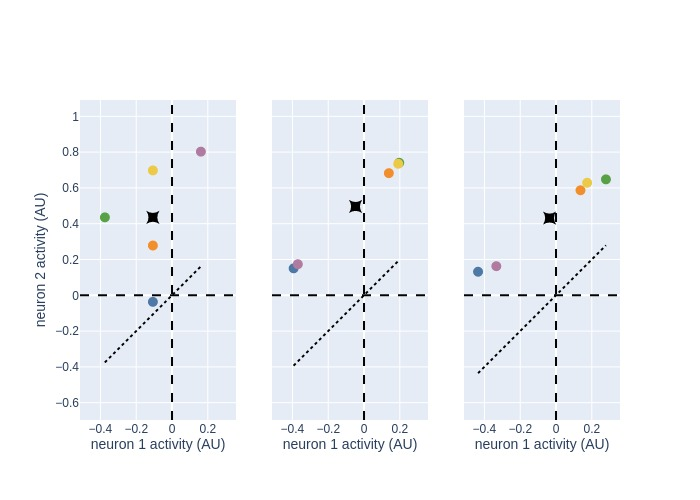

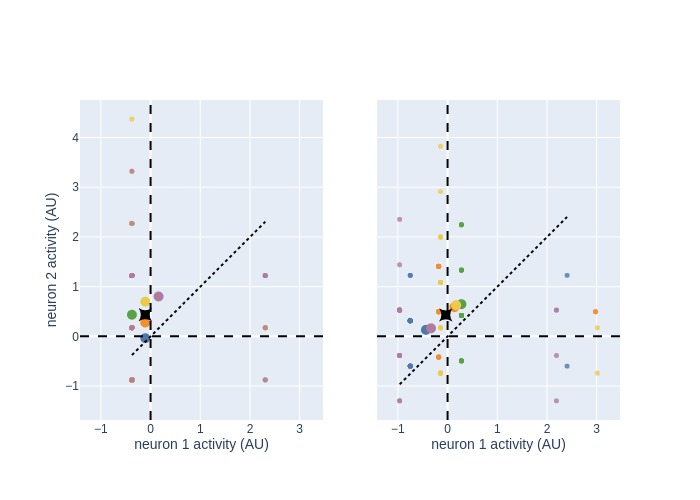

In [20]:
badcells = [0,1]
badprobe = 2
badtime = 6
# select a problematic subset: 2 neurons, 1 probe, 1 time point
bad_raster = raster[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]
simp_diag = simple_diag[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]
bad_diag = fano_diag[:,np.asarray(badcells),...][...,badprobe,badtime][:,:,:,None,None]


fig = plot_eg_diag([
    # bad_raster,
    bad_raster.mean(axis=0, keepdims=True),
    # simp_diag,
    simp_diag.mean(axis=0, keepdims=True),
    # bad_diag,
    bad_diag.mean(axis=0, keepdims=True)
])

fig.show(renderer='jpeg')
fig = plot_eg_diag([bad_raster, bad_diag])
fig.show(renderer='jpeg')

# All sites

same pipeline for all sites

In [21]:
# quick cache
acc_df_file = pl.Path(config['paths']['analysis_cache']) / f'230220_SC_decoder_accuracies'

recache_acc = False

if acc_df_file.exists() and not recache_acc:
    print('DF cache found, reloading')
    accuracy_df = jl.load(acc_df_file)

elif (not acc_df_file.exists()) or recache_acc:
    print('creating DF of site decoder accuracies ...')
    accuracy_df = list()
    for site in good_sites:
    # for site in [eg_site]:
        fn = load_site_formated_raster
        if fn.check_call_in_cache(site, **raster_meta):
            print(f'cache found for {site}')
            raster, _ = fn(site, **raster_meta)
        else:
            print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")

        nsounds = raster.shape[3]
        codes = dict(sparse= raster,
                     dense = diag_and_scale(raster, mode='mean_var'))

        for code, rast in codes.items():
            unfolded, labels = unfold_rep_ctx_prb(rast)
            for part in ['context', 'probe']:
                accuracy, chance = get_svm_accuracy(unfolded, labels[part])

                d = {'site': site,
                     'code': code,
                     'part': part,
                     'accuracy': accuracy,
                     'chance': chance,
                     'nsounds': nsounds}

                accuracy_df.append(d)

    accuracy_df = pd.DataFrame(accuracy_df)
    print('... done creating DF')

    jl.dump(accuracy_df, acc_df_file)

DF cache found, reloading


### plots the cumulative data
lets see how the decoder analysis performs for all sites in their starting sparse encoding, and then once transformed
to the different dense codes

In [22]:
folder = root_path / 'reports' / 'figures' / 'decoder'
folder.mkdir(parents=True, exist_ok=True)

In [23]:

part = 'context'
code = 'sparse'
nsounds = 4

def plot_acc_from_df(fnDF, part, code, nsounds, color='black', showlegend=False):
    fig = go.Figure()
    indf = fnDF.query(f"part=='{part}' and code=='{code}' and nsounds=={nsounds}")
    chance = indf.chance.unique()[0]
    arr = np.stack(indf.loc[:, 'accuracy'].values)

    t = np.linspace(0, 1, arr.shape[1], endpoint=False)  # hardcoded 0 to 1 timeframe, fine for now
    # individual lines, damn you plotly for this verbose monster
    for l in arr:
        fig.add_trace(
            go.Scatter(x=t, y=l, mode='lines', opacity=0.3, showlegend=False,
                       line=dict(color=add_opacity(name_to_hex(color), 0.3)),
                       )
        )

    # mean of all lines
    fig.add_trace(
            go.Scatter(x=t, y=arr.mean(axis=0), mode='lines', showlegend=showlegend,
                       line=dict(color=color), name=f'{part}_{code}'
                       )
        )

    # chance line
    fig.add_trace(
            go.Scatter(x=[t[0],t[-1]], y=[chance]*2, mode='lines', showlegend=showlegend,
                       line=dict(color=color, dash='dot'), name=f'chance={chance}'
                       )
        )

    return fig

# fig = plot_acc_from_df(accuracy_df, part, code, nsounds, color='salmon')
# fig.show(renderer='jpeg')

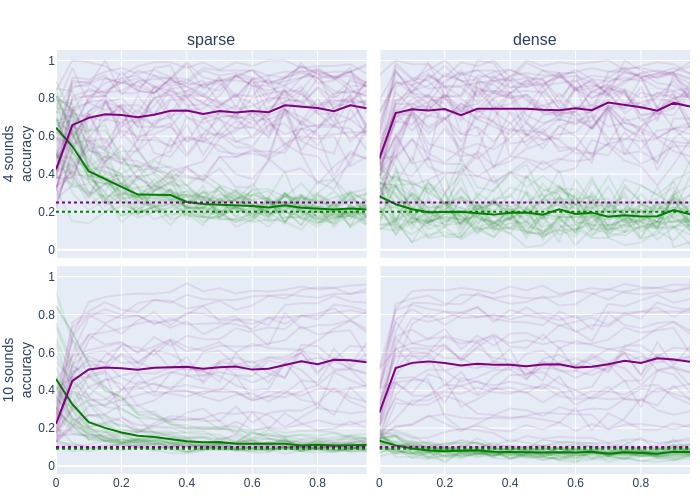

In [24]:
encodings = ['sparse', 'dense']
parts = ['context', 'probe']
nsounds = [4, 10]

fig = make_subplots(rows=2, cols=2, shared_xaxes='all', shared_yaxes='all',
                    subplot_titles= encodings + ['',''],
                    vertical_spacing=0.02, horizontal_spacing=0.02)

for cc, code in enumerate(encodings):
    for rr, ns in enumerate(nsounds):
        for part, color in zip(parts, ['green', 'purple']):
             f = plot_acc_from_df(accuracy_df, part, code, nsounds=ns, color=color)['data']
             fig.add_traces(f, rows=[rr+1]*len(f), cols=[cc+1]*len(f))


fig.update_layout(margin={'t':50, 'l':50, 'b': 10, 'r': 10})

for rr, ns in enumerate(nsounds):
    # [f'{ns} sounds' for ns in nsounds]
    fig.update_yaxes(title=dict(text=f'{ns} sounds<br>accuracy', standoff=0),
                     row=rr+1, col=1)
for cc in range(1,3):
    fig.update_xaxes(title=dict(text='time from probe (s)', standoff=0),
                     row=3, col=cc)

filename = folder / 'all_4sound_sites_accuracy'
fig.write_image(filename.with_suffix('.png'), scale=1)

fig.show(renderer='jpeg')